### NB: nella prima slide spiegare le 'Feature', ovvero i vari metodi utilizzati per questo indicatore

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [18]:
df = pd.read_csv('data/W/gho-tobacco-control-warnings-cigarette-w8-princ-langs-a.csv')
df

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2022,...,NaN,NaN,NaN,NaN,NaN,No,823,NaN,EN,2023-12-13T23:00:00.000Z
1,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AFR,Africa,Country,DZA,Algeria,Year,2022,...,NaN,NaN,NaN,NaN,NaN,No,823,Regulations are pending.,EN,2023-12-13T23:00:00.000Z
2,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AMR,Americas,Country,BHS,Bahamas,Year,2022,...,NaN,NaN,NaN,NaN,NaN,No,823,NaN,EN,2023-12-13T23:00:00.000Z
3,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,SEAR,South-East Asia,Country,BTN,Bhutan,Year,2022,...,NaN,NaN,NaN,NaN,NaN,No,823,NaN,EN,2023-12-13T23:00:00.000Z
4,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AFR,Africa,Country,CPV,Cabo Verde,Year,2022,...,NaN,NaN,NaN,NaN,NaN,No,823,NaN,EN,2023-12-13T23:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AMR,Americas,Country,USA,United States of America,Year,2007,...,NaN,NaN,NaN,NaN,NaN,Yes,364,NaN,EN,2023-12-13T23:00:00.000Z
1751,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AMR,Americas,Country,URY,Uruguay,Year,2007,...,NaN,NaN,NaN,NaN,NaN,Yes,364,NaN,EN,2023-12-13T23:00:00.000Z
1752,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,WPR,Western Pacific,Country,VUT,Vanuatu,Year,2007,...,NaN,NaN,NaN,NaN,NaN,Yes,364,NaN,EN,2023-12-13T23:00:00.000Z
1753,W8_princ_langs_A,Are the health warnings on cigarette packaging...,text,AMR,Americas,Country,VEN,Venezuela (Bolivarian Republic of),Year,2007,...,NaN,NaN,NaN,NaN,NaN,Yes,364,NaN,EN,2023-12-13T23:00:00.000Z


In [19]:
DATA_DIR = Path("./Data/W")  # change if your CSVs are elsewhere

files = {
    "princ_langs": DATA_DIR / "gho-tobacco-control-warnings-cigarette-w8-princ-langs-a.csv",
    "front_back": DATA_DIR / "gho-tobacco-control-warnings-cigarettes-w2-pc-front-back-a.csv",
    "font_spec": DATA_DIR / "gho-tobacco-control-warnings-cigarettes-w6-font-a.csv",
    "rotation": DATA_DIR / "gho-tobacco-control-warnings-cigarettes-w7-rotation-a.csv",
    "graphic": DATA_DIR / "gho-tobacco-control-warnings-cigarettes-w10-graphic-a.csv",
    "smokeless_law": DATA_DIR / "gho-tobacco-control-warnings-smokeless-w1-hw-law-c.csv",
}


def read_csv_any(path: Path) -> pd.DataFrame:
    for enc in ["utf-8-sig", "utf-8", "latin-1"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    return pd.read_csv(path, engine="python")


raw = {k: read_csv_any(p) for k, p in files.items()}

KEEP = ["ParentLocation", "Location", "Period", "Value", "ValueType", "IndicatorCode", "Indicator"]


def yesno_to_flag(s: pd.Series) -> pd.Series:
    x = s.fillna("").str.strip().str.lower()
    out = pd.Series(np.nan, index=s.index, dtype="float")
    out[x.isin(["yes", "y"])] = 1.0
    out[x.isin(["no", "n"])] = 0.0
    return out


def smokeless_law_flag(s: pd.Series) -> pd.Series:
    x = s.fillna("").str.strip().str.lower()
    out = pd.Series(np.nan, index=s.index, dtype="float")
    out[x.eq("yes")] = 1.0
    out[x.eq("no")] = 0.0
    # treat “Sale is banned” as protective
    out[x.eq("sale is banned")] = 1.0
    return out


def base_df(raw_key, rename_to, mapper=None, numeric=False):
    df = raw[raw_key][KEEP].rename(columns={"ParentLocation": "Region"}).copy()
    df["feature"] = rename_to
    if numeric:
        df["flag"] = pd.to_numeric(df["Value"], errors="coerce")
    else:
        df["flag"] = (mapper(df["Value"]) if mapper else yesno_to_flag(df["Value"]))
    return df


# Build long panel
df_princ = base_df("princ_langs", "principal_languages")
df_font = base_df("font_spec", "font_spec")
df_rot = base_df("rotation", "rotation")
df_graph = base_df("graphic", "graphic")
df_fb = base_df("front_back", "front_back_pct", numeric=True)
df_smokeless = base_df("smokeless_law", "smokeless_law", mapper=smokeless_law_flag)

features = pd.concat([df_princ, df_font, df_rot, df_graph, df_fb, df_smokeless], ignore_index=True)

# Pass/fail rule (≥50% for front+back)
features["pass"] = features["flag"]
is_fb = features["feature"].eq("front_back_pct")
features.loc[is_fb, "pass"] = (features.loc[is_fb, "flag"] >= 50).astype(float)
features.loc[~is_fb, "pass"] = features.loc[~is_fb, "flag"]

features.to_csv("w_features_clean.csv", index=False)

# Wide per country-year + best-practice composite
feat_list = ["graphic", "rotation", "principal_languages", "font_spec", "front_back_pct"]
wide = (features[features["feature"].isin(feat_list + ["smokeless_law"])]
        .pivot_table(index=["Region", "Location", "Period"], columns="feature", values="pass", aggfunc="max")
        .reset_index())

wide["best_practice_cig"] = (
        wide[["graphic", "rotation", "principal_languages", "font_spec", "front_back_pct"]].fillna(0).sum(axis=1) == 5
).astype(int)

# Latest year slices
latest_year = wide.groupby(["Region", "Location"])["Period"].transform("max")
latest = wide[wide["Period"].eq(latest_year)].copy()
latest.to_csv("w_country_summary_latest.csv", index=False)

region_summary = (latest.groupby("Region")[["graphic", "rotation", "principal_languages",
                                            "font_spec", "front_back_pct", "best_practice_cig", "smokeless_law"]]
                  .mean(numeric_only=True).reset_index())
region_summary.to_csv("w_region_summary_latest.csv", index=False)

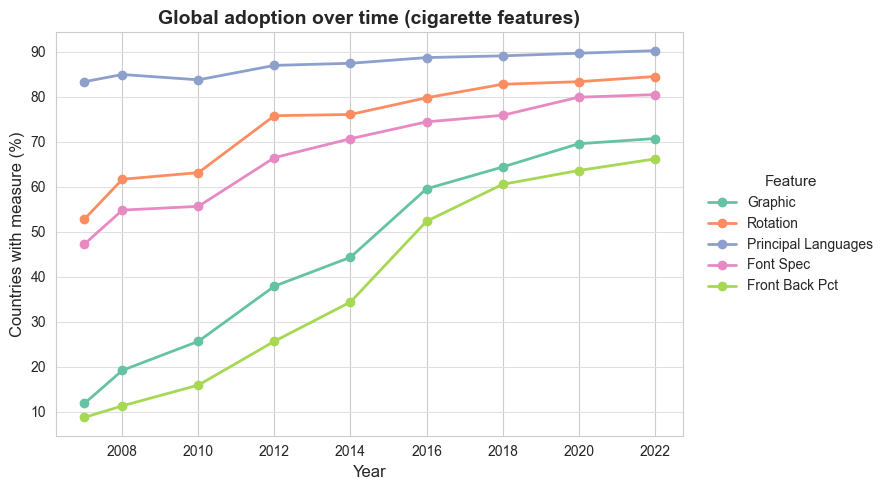

In [20]:
plt.figure(figsize=(9, 5))
palette = sns.color_palette("Set2", n_colors=len(feat_list))

global_time = (
    features[features["feature"].isin(feat_list)]
    .groupby(["Period", "feature"])
    .agg(pass_rate=("pass", lambda s: np.nanmean(s) * 100))
    .reset_index()
)

for i, feat in enumerate(feat_list):
    g = global_time[global_time["feature"] == feat]
    plt.plot(
        g["Period"], g["pass_rate"],
        marker="o", linewidth=2, label=feat.replace("_", " ").title(),
        color=palette[i]
    )

plt.title("Global adoption over time (cigarette features)", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Countries with measure (%)", fontsize=12)
plt.legend(title="Feature", frameon=False, fontsize=10, title_fontsize=11, loc="center left",
           bbox_to_anchor=(1.02, 0.5))
plt.grid(axis="y", color="#e0e0e0", linewidth=0.8)
plt.tight_layout()
plt.show()

> - **Title**: Global adoption over time - % of countries adopting each measure (2006–2022).
> - Key messages
>     - Principal languages: high and steady, ~90% in 2022 (near-universal).
>     - Message rotation: ~53% (2007) → ~85% (2022) (+32 %).
>     - Font specifications: ~47% → ~80% (+33 %).
>     - Graphic (pictorial) warnings: sharp rise ~12% → ~70% (+58 %).
>     - Front & Back ≥50% of principal display area: ~9% → ~66% (+57 %), with a clear 2014→2016 step-change.

In [21]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("./data/W/clusterA")  # cambia se i CSV non sono nella stessa cartella

files = {
    # Law mandates
    "law_cig": DATA_DIR / "Tobacco health warnings appear on cigarette packages, law mandates.csv",
    "law_osm": DATA_DIR / "Tobacco health warnings appear on other smoked tobacco packages, law mandates.csv",
    "law_sml": DATA_DIR / "Tobacco health warnings appear on smokeless tobacco packages, law mandates.csv",
    # Each package & outside packaging
    "each_cig": DATA_DIR / "Tobacco health warnings appear on each cigarette package and any outside packaging and labelling used in the retail sale.csv",
    "each_osm": DATA_DIR / "Tobacco health warnings appear on each other smoked tobacco package and any outside packaging and labelling used in the retail sale.csv",
    "each_sml": DATA_DIR / "Tobacco health warnings appear on each smokeless tobacco package and any outside packaging and labelling used in the retail sale.csv",
    # Front & back %
    "fb_cig": DATA_DIR / "Tobacco warning front and back of cigarette packaging, % of principal display area mandated.csv",
    "fb_osm": DATA_DIR / "Tobacco warning  front and back of other smoked tobacco packaging, % of principal display area mandated to be covered by health warnings.csv",
    "fb_sml": DATA_DIR / "Tobacco warning front and back of smokeless tobacco packaging, % of principal display area mandated to be covered by health warnings.csv",
}


def read_csv_any(p: Path) -> pd.DataFrame:
    for enc in ["utf-8-sig", "utf-8", "latin-1"]:
        try:
            return pd.read_csv(p, encoding=enc)
        except Exception:
            pass
    return pd.read_csv(p, engine="python")


raw = {k: read_csv_any(p) for k, p in files.items()}

KEEP = ["ParentLocation", "Location", "Period", "Value", "ValueType", "IndicatorCode", "Indicator"]
REN_REGION = {"ParentLocation": "Region"}


def yesno_flag(s: pd.Series) -> pd.Series:
    x = s.fillna("").str.strip().str.lower()
    out = pd.Series(np.nan, index=s.index, dtype="float")
    out[x.isin(["yes", "y"])] = 1.0
    out[x.isin(["no", "n"])] = 0.0
    return out


def pct_from_value(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")


def build_table(df: pd.DataFrame, feature_name: str, mapper) -> pd.DataFrame:
    t = df[KEEP].rename(columns=REN_REGION).copy()
    t["feature"] = feature_name
    t["val"] = mapper(t["Value"])
    return t


tables = []
# Law mandate flags
tables += [build_table(raw["law_cig"], "law_cig", yesno_flag)]
tables += [build_table(raw["law_osm"], "law_osm", yesno_flag)]
tables += [build_table(raw["law_sml"], "law_sml", yesno_flag)]
# Each package flags
tables += [build_table(raw["each_cig"], "eachpkg_cig", yesno_flag)]
tables += [build_table(raw["each_osm"], "eachpkg_osm", yesno_flag)]
tables += [build_table(raw["each_sml"], "eachpkg_sml", yesno_flag)]
# Front & back % (numeric)
tables += [build_table(raw["fb_cig"], "fbpct_cig", pct_from_value)]
tables += [build_table(raw["fb_osm"], "fbpct_osm", pct_from_value)]
tables += [build_table(raw["fb_sml"], "fbpct_sml", pct_from_value)]

long = pd.concat(tables, ignore_index=True)

# Create pass flags
long["pass"] = np.nan
for k in ["law_cig", "law_osm", "law_sml", "eachpkg_cig", "eachpkg_osm", "eachpkg_sml"]:
    m = long["feature"].eq(k)
    long.loc[m, "pass"] = long.loc[m, "val"]

for k in ["fbpct_cig", "fbpct_osm", "fbpct_sml"]:
    m = long["feature"].eq(k)
    long.loc[m, "pass"] = (long.loc[m, "val"] >= 50).astype(float)

# Wide per country-year
wide = (long.pivot_table(index=["Region", "Location", "Period"], columns="feature",
                         values="pass", aggfunc="max")
        .reset_index())

# Strict compliance per product: law==1 & eachpkg==1 & fb>=50
for prd in ["cig", "osm", "sml"]:
    cols = [f"law_{prd}", f"eachpkg_{prd}", f"fbpct_{prd}"]
    wide[f"A_strict_{prd}"] = (wide[cols].fillna(0).sum(axis=1) == 3).astype(int)

# Latest year slice per country
wide["latest_year"] = wide.groupby(["Region", "Location"])["Period"].transform("max")
latest = wide[wide["Period"].eq(wide["latest_year"])].copy()

# Save summaries
wide.to_csv("clusterA_panel.csv", index=False)
latest.to_csv("clusterA_latest.csv", index=False)

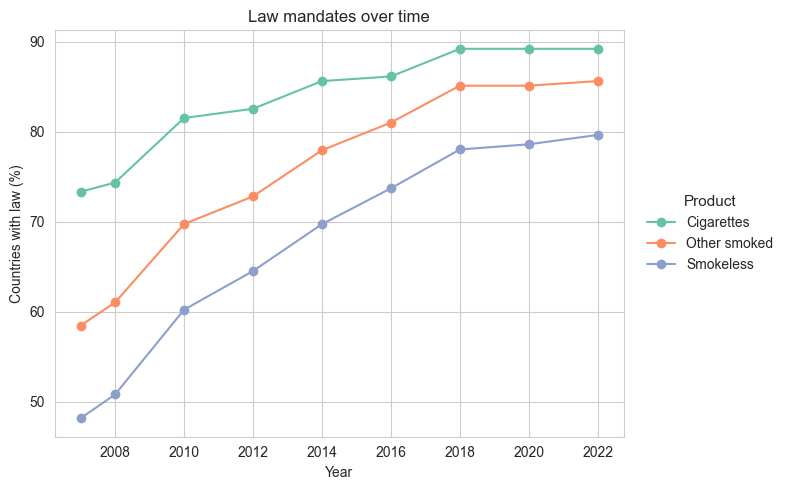

In [22]:
import matplotlib.pyplot as plt

law_feats = ["law_cig", "law_osm", "law_sml"]
global_law = (
    long[long["feature"].isin(law_feats)]
    .groupby(["Period", "feature"])
    .agg(share=("pass", lambda s: np.nanmean(s) * 100))
    .reset_index()
)
palette = sns.color_palette("Set2", n_colors=3)

plt.figure(figsize=(8, 5))
for feat, label in [("law_cig", "Cigarettes"), ("law_osm", "Other smoked"), ("law_sml", "Smokeless")]:
    sub = global_law[global_law["feature"].eq(feat)]
    plt.plot(sub["Period"], sub["share"], marker="o", label=label,
             color=palette[["law_cig", "law_osm", "law_sml"].index(feat)])
plt.title("Law mandates over time")
plt.xlabel("Year")
plt.ylabel("Countries with law (%)")
plt.grid(True, axis="y")
plt.legend(
    title="Product",
    frameon=False,
    fontsize=10,
    title_fontsize=11,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)
plt.tight_layout()
plt.show()

> - **Title**: Countries with a law mandating pack health warnings
> - Key messages:
>     - Cigarettes: ~73% → ~89%; growth through 2018, then a plateau.
>     - Other smoked (OSM): ~58% → ~86%; steady rise to 2018, then stable.
>     - Smokeless (SML): ~48% → ~80% (+32%), the largest gain but still below smoked products.
>     - SML vs Cigarettes gap: narrows from ~25% (2007) to ~9–10% (2022).

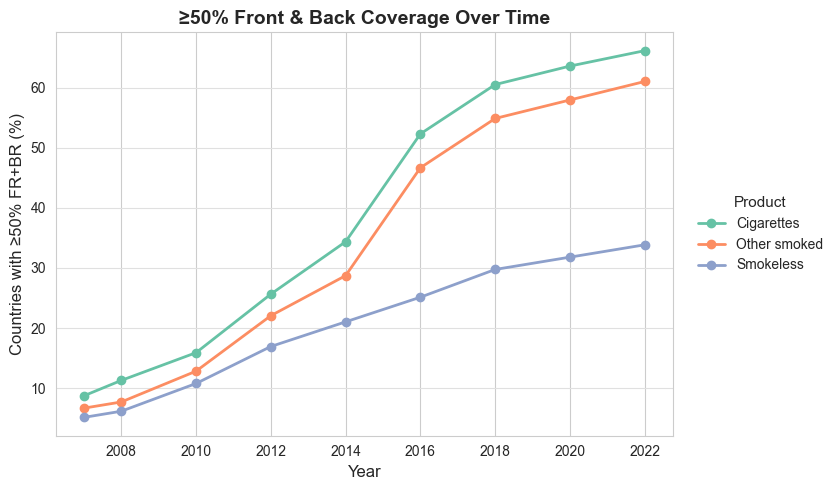

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("Set2", n_colors=3)
fb_feats = ["fbpct_cig", "fbpct_osm", "fbpct_sml"]
trend_fb = (
    long[long["feature"].isin(fb_feats)]
    .groupby(["Period", "feature"])
    .agg(share=("pass", lambda s: np.nanmean(s) * 100))
    .reset_index()
)
label_fb = {"fbpct_cig": "Cigarettes", "fbpct_osm": "Other smoked", "fbpct_sml": "Smokeless"}

# Add a label column for plotting
trend_fb["label"] = trend_fb["feature"].map(label_fb)

plt.figure(figsize=(8.5, 5))
for i, lab in enumerate(["Cigarettes", "Other smoked", "Smokeless"]):
    sub = trend_fb[trend_fb["label"] == lab]
    plt.plot(
        sub["Period"], sub["share"],
        marker="o", linewidth=2, label=lab,
        color=palette[i]
    )

plt.title("≥50% Front & Back Coverage Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Countries with ≥50% FR+BR (%)", fontsize=12)
plt.legend(title="Product", frameon=False, fontsize=10, title_fontsize=11, loc="center left",
           bbox_to_anchor=(1.02, 0.5))
plt.grid(axis="y", color="#e0e0e0", linewidth=0.8)
plt.tight_layout()
plt.show()

> - **Title**: ≥50% FR+BR pack coverage
> - Key messages:
>     - 2014→2016 inflection: sharp uptake for smoked products.
>     - 2022 levels: Cigarettes ~66%, Other smoked ~61%, Smokeless ~34%.
>     - SML gap: 30% below cigarettes; slower growth after 2018.

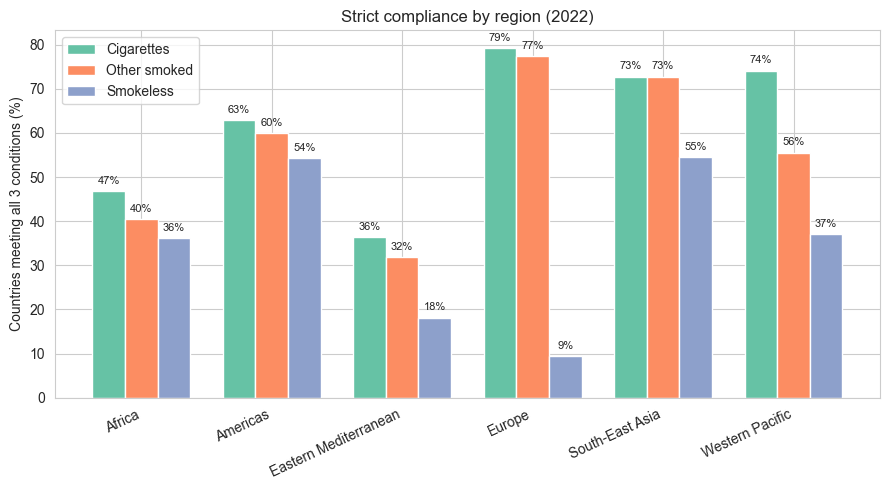

In [24]:
# ---------- Plot 3: 2022 by-region — Strict Cluster-A compliance ----------
yr_latest = int(long["Period"].max())
byreg = (latest.groupby("Region")[["A_strict_cig", "A_strict_osm", "A_strict_sml"]]
         .mean(numeric_only=True).mul(100).reset_index())

palette = sns.color_palette("Set2", n_colors=3)

x = np.arange(len(byreg["Region"]))
w = 0.25
plt.figure(figsize=(9, 5))
plt.bar(x - w, byreg["A_strict_cig"], width=w, label="Cigarettes", color=palette[0])
plt.bar(x, byreg["A_strict_osm"], width=w, label="Other smoked", color=palette[1])
plt.bar(x + w, byreg["A_strict_sml"], width=w, label="Smokeless", color=palette[2])
plt.title(f"Strict compliance by region ({yr_latest})")
plt.ylabel("Countries meeting all 3 conditions (%)")
plt.xticks(x, byreg["Region"], rotation=25, ha="right")
for i, v in enumerate(byreg["A_strict_cig"]): plt.text(x[i] - w, v + 1.2, f"{v:.0f}%", ha="center", va="bottom",
                                                       fontsize=8)
for i, v in enumerate(byreg["A_strict_osm"]): plt.text(x[i], v + 1.2, f"{v:.0f}%", ha="center", va="bottom", fontsize=8)
for i, v in enumerate(byreg["A_strict_sml"]): plt.text(x[i] + w, v + 1.2, f"{v:.0f}%", ha="center", va="bottom",
                                                       fontsize=8)
plt.legend()
plt.tight_layout()
plt.show()

- **Title**: % of countries meeting all 3 packaging requirements: law in force, warning on each package, ≥50% front+back coverage.
- Key messages:
    - Europe leads for smoked products: Cigarettes 79%, Other smoked 77%; Smokeless only 9% → large SML gap.
    - South-East Asia is strong on smoked (73% / 73%) and has the highest SML at 55%.
    - Americas are solid and balanced: 63% / 60% / 54%.
    - Western Pacific: Cigarettes 74%, but OSM 56% and SML 37%.
    - Africa mid-range (47% / 40% / 36%); Eastern Mediterranean lags, especially SML 18%.

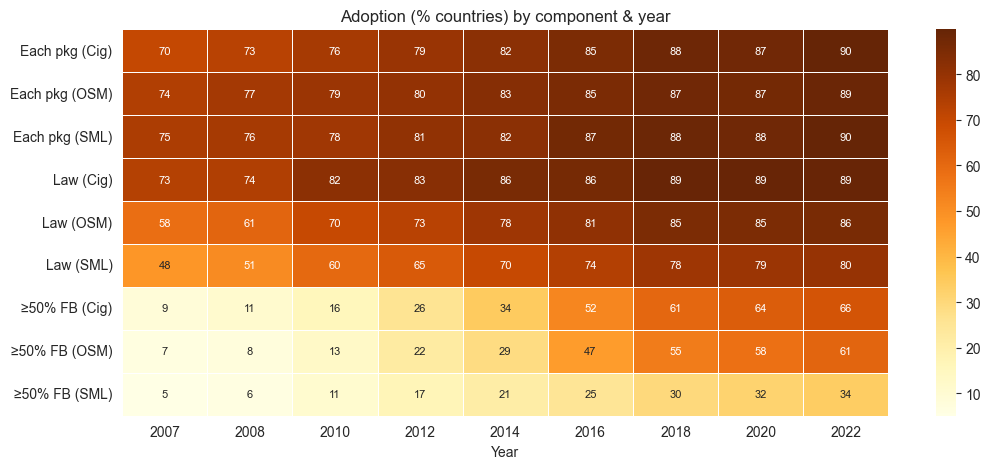

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. Global adoption heatmap (features × year)
# -----------------------------
# Inspect features present in `long`
feat_vals = sorted(long["feature"].unique())

# Define expected schemas
cig_feat_order = ["graphic", "rotation", "principal_languages", "font_spec", "front_back_pct"]
clusterA_map = {
    "law_cig": "Law (Cig)", "eachpkg_cig": "Each pkg (Cig)", "fbpct_cig": "≥50% FB (Cig)",
    "law_osm": "Law (OSM)", "eachpkg_osm": "Each pkg (OSM)", "fbpct_osm": "≥50% FB (OSM)",
    "law_sml": "Law (SML)", "eachpkg_sml": "Each pkg (SML)", "fbpct_sml": "≥50% FB (SML)"
}

if all(f in feat_vals for f in cig_feat_order):
    # 5-feature schema
    present = [f for f in cig_feat_order if f in feat_vals]
    heat = (
        long[long["feature"].isin(present)]
        .groupby(["Period", "feature"])
        .agg(rate=("pass", lambda s: float(np.nanmean(s) * 100)))
        .reset_index()
        .pivot(index="feature", columns="Period", values="rate")
        .reindex(present)
    )
    heat = heat.apply(pd.to_numeric, errors="coerce").dropna(axis=1, how="all")
    plt.figure(figsize=(10, 3.2))
    sns.heatmap(heat, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True, linewidths=0.5, annot_kws={"fontsize": 9})
    plt.title("Global adoption (% countries) by feature & year")
    plt.ylabel("")
    plt.xlabel("Year")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

elif any(f in feat_vals for f in clusterA_map):
    # Cluster-A schema
    use_feats = [f for f in clusterA_map if f in feat_vals]
    heatA = (
        long[long["feature"].isin(use_feats)]
        .groupby(["Period", "feature"])
        .agg(rate=("pass", lambda s: float(np.nanmean(s) * 100)))
        .reset_index()
    )
    heatA["row"] = heatA["feature"].map(clusterA_map)
    pivotA = (heatA.pivot(index="row", columns="Period", values="rate")
              .sort_index())
    pivotA = pivotA.apply(pd.to_numeric, errors="coerce").dropna(axis=1, how="all")
    plt.figure(figsize=(11, 4.8))
    sns.heatmap(pivotA, annot=True, fmt=".0f", cmap="YlOrBr", cbar=True, linewidths=0.4, annot_kws={"fontsize": 8})
    plt.title("Adoption (% countries) by component & year")
    plt.ylabel("")
    plt.xlabel("Year")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    raise ValueError(
        "Unrecognized feature set in `long`. Neither the 5-feature cigarette schema nor Cluster-A schema detected.\n"
        f"Features found: {feat_vals}\n"
        "Run the correct data-prep section before plotting."
    )

> - **Title**: Adoption (% of countries) by component and year, 2007–2022.
> - Key messages:
>     - **Each package**: coverage is ~90% in 2022 for cigarettes, other smoked tobacco (OSM), and smokeless tobacco (SML).
>     - **Law in force**: clear growth; SML rises from 48% (2007) to 80% (2022); OSM ≈ 86% (2022).
>     - **50% Front + Back** (principal display area): step change in 2014→2016; in 2022 — Cigarettes 66%, OSM 61%, SML 34%.
>     - **Takeaway**: baseline standards are widespread; stricter ≥50% FB requirements are not yet universal, especially for SML.

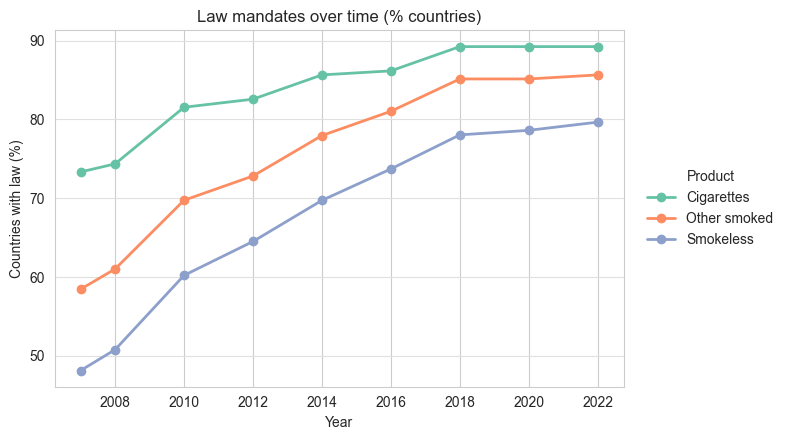

In [26]:
# -----------------------------
# 2. Law mandate trends (rebuild 'global_law')
# -----------------------------
law_feats = ["law_cig", "law_osm", "law_sml"]
global_law = (
    long[long["feature"].isin(law_feats)]
    .groupby(["Period", "feature"])
    .agg(share=("pass", lambda s: np.nanmean(s) * 100))
    .reset_index()
)
palette = sns.color_palette("Set2", n_colors=3)
plt.figure(figsize=(8, 4.5))
label_map = {"law_cig": "Cigarettes", "law_osm": "Other smoked", "law_sml": "Smokeless"}
for i, f in enumerate(law_feats):
    sub = global_law[global_law["feature"] == f]
    plt.plot(sub["Period"], sub["share"], marker="o", linewidth=2,
             label=label_map[f], color=palette[i])
plt.title("Law mandates over time (% countries)")
plt.xlabel("Year")
plt.ylabel("Countries with law (%)")
plt.legend(title="Product", frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.grid(axis="y", color="#e0e0e0", linewidth=0.8)
plt.tight_layout()
plt.show()

> - **Title**: Countries with law mandating pack health warnings
> - Key messages:
>     - **Cigarettes**: from ~73% (2007) to ~89% (2018–2022) — high and stable.
>     - **Other smoked (OSM)**: from ~59% to ~86% (+27%).
>     - **Smokeless (SML)**: from ~48% to ~80% (+32 %) — the largest gain, but still lags smoked products.
>     - **SML vs Cigarettes gap**: narrows from ~25% (2007) to ~9% (2022). Rapid uptake in 2008–2014, then a plateau after 2018.

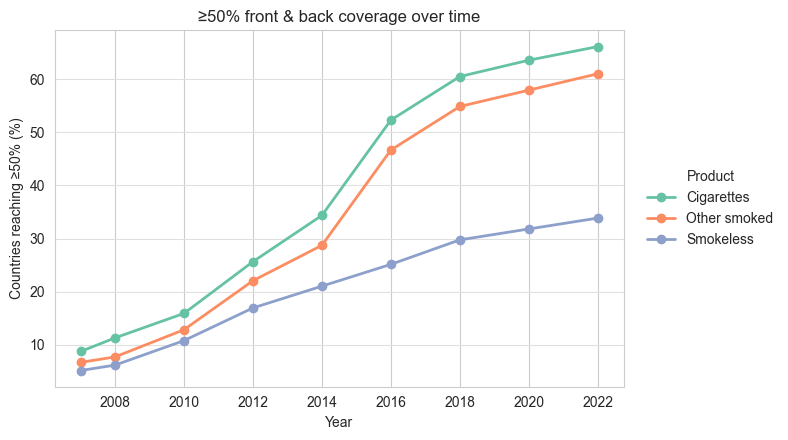

In [27]:
# -----------------------------
# 3. ≥50% front & back coverage trends (rebuild 'trend_fb')
# -----------------------------

palette = sns.color_palette("Set2", n_colors=3)

fb_feats = ["fbpct_cig", "fbpct_osm", "fbpct_sml"]
trend_fb = (
    long[long["feature"].isin(fb_feats)]
    .groupby(["Period", "feature"])
    .agg(share=("pass", lambda s: np.nanmean(s) * 100))
    .reset_index()
)
label_fb = {"fbpct_cig": "Cigarettes", "fbpct_osm": "Other smoked", "fbpct_sml": "Smokeless"}
fb_palette = ["#388e3c", "#1976d2", "#d32f2f"]
plt.figure(figsize=(8, 4.5))
for i, f in enumerate(fb_feats):
    sub = trend_fb[trend_fb["feature"] == f]
    plt.plot(sub["Period"], sub["share"], marker="o", linewidth=2,
             label=label_fb[f], color=palette[i])
plt.title("≥50% front & back coverage over time")
plt.xlabel("Year")
plt.ylabel("Countries reaching ≥50% (%)")
plt.legend(title="Product", frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.grid(axis="y", color="#e0e0e0", linewidth=0.8)
plt.tight_layout()
plt.show()

> - **Title**: ≥50% front & back coverage on packs
> - Key messages
>     - 2014→2016 inflection: sharp uptake for smoked products (Cigarettes ~+19%; Other smoked ~+20%).
>     - 2022 levels: Cigarettes ~65%, Other smoked ~61%, Smokeless ~34%.
>     - Persistent gap for SML: about 30% below cigarettes in 2022; slower progress after 2018.
>     - Overall pattern: from very low adoption in the late 2000s to broad uptake for smoked products; smokeless lags behind.